# Euclidean space

* Load original embeddings
* Euclidean MDS

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns
from sklearn.manifold import MDS
from scipy import stats
from scipy.spatial import distance_matrix

data_dir = '../data'
output_dir = '../outputs'

In [2]:
input_distance_matrix = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
input_distance_matrix.shape

(49, 49)

In [3]:
embedding = MDS(n_components=3)
transformed_dist = embedding.fit_transform(input_distance_matrix)
# eu_dist = np.corrcoef(transformed_dist, rowvar=True)
# eu_dist = 1 - abs(eu_dist)
eu_dist = distance_matrix(transformed_dist, transformed_dist)

stats.spearmanr(eu_dist.flatten(),input_distance_matrix.flatten()) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


SpearmanrResult(correlation=0.3592348973240161, pvalue=4.7569986413006544e-74)

In [4]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [5]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [6]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


# Analysis

1. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
2. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        


In [7]:
### normalize embeddings and transform concept embeddings to loadings in feature space
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
concept_in_feat_coord = normalized_embeddings@transformed_dist
np.array(concept_in_feat_coord).shape

(1854, 3)

In [8]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(concept_in_feat_coord).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,cr,bigcat,cat_name
0,0,1.039550,0.005882,-0.358634,0.779739,1,animal
1,1,0.306624,0.133821,-0.758165,0.798485,13,home decor
2,2,0.857948,-0.024155,-0.545741,0.752845,18,musical instrument
4,4,0.631593,-0.094784,-1.120267,0.794466,9,electronic device
5,5,0.322682,-0.226267,-0.834044,0.806000,12,furniture
...,...,...,...,...,...,...,...
1847,1847,-0.337758,0.398110,0.799413,0.803129,24,toy
1848,1848,0.726302,-0.806779,-0.045612,0.765881,10,food
1850,1850,0.543909,-0.359043,-0.042410,0.843158,10,food
1851,1851,0.853482,0.278937,-0.651413,0.800163,1,animal


In [77]:
transformed_dist.shape

(49, 3)

<IPython.core.display.Javascript object>


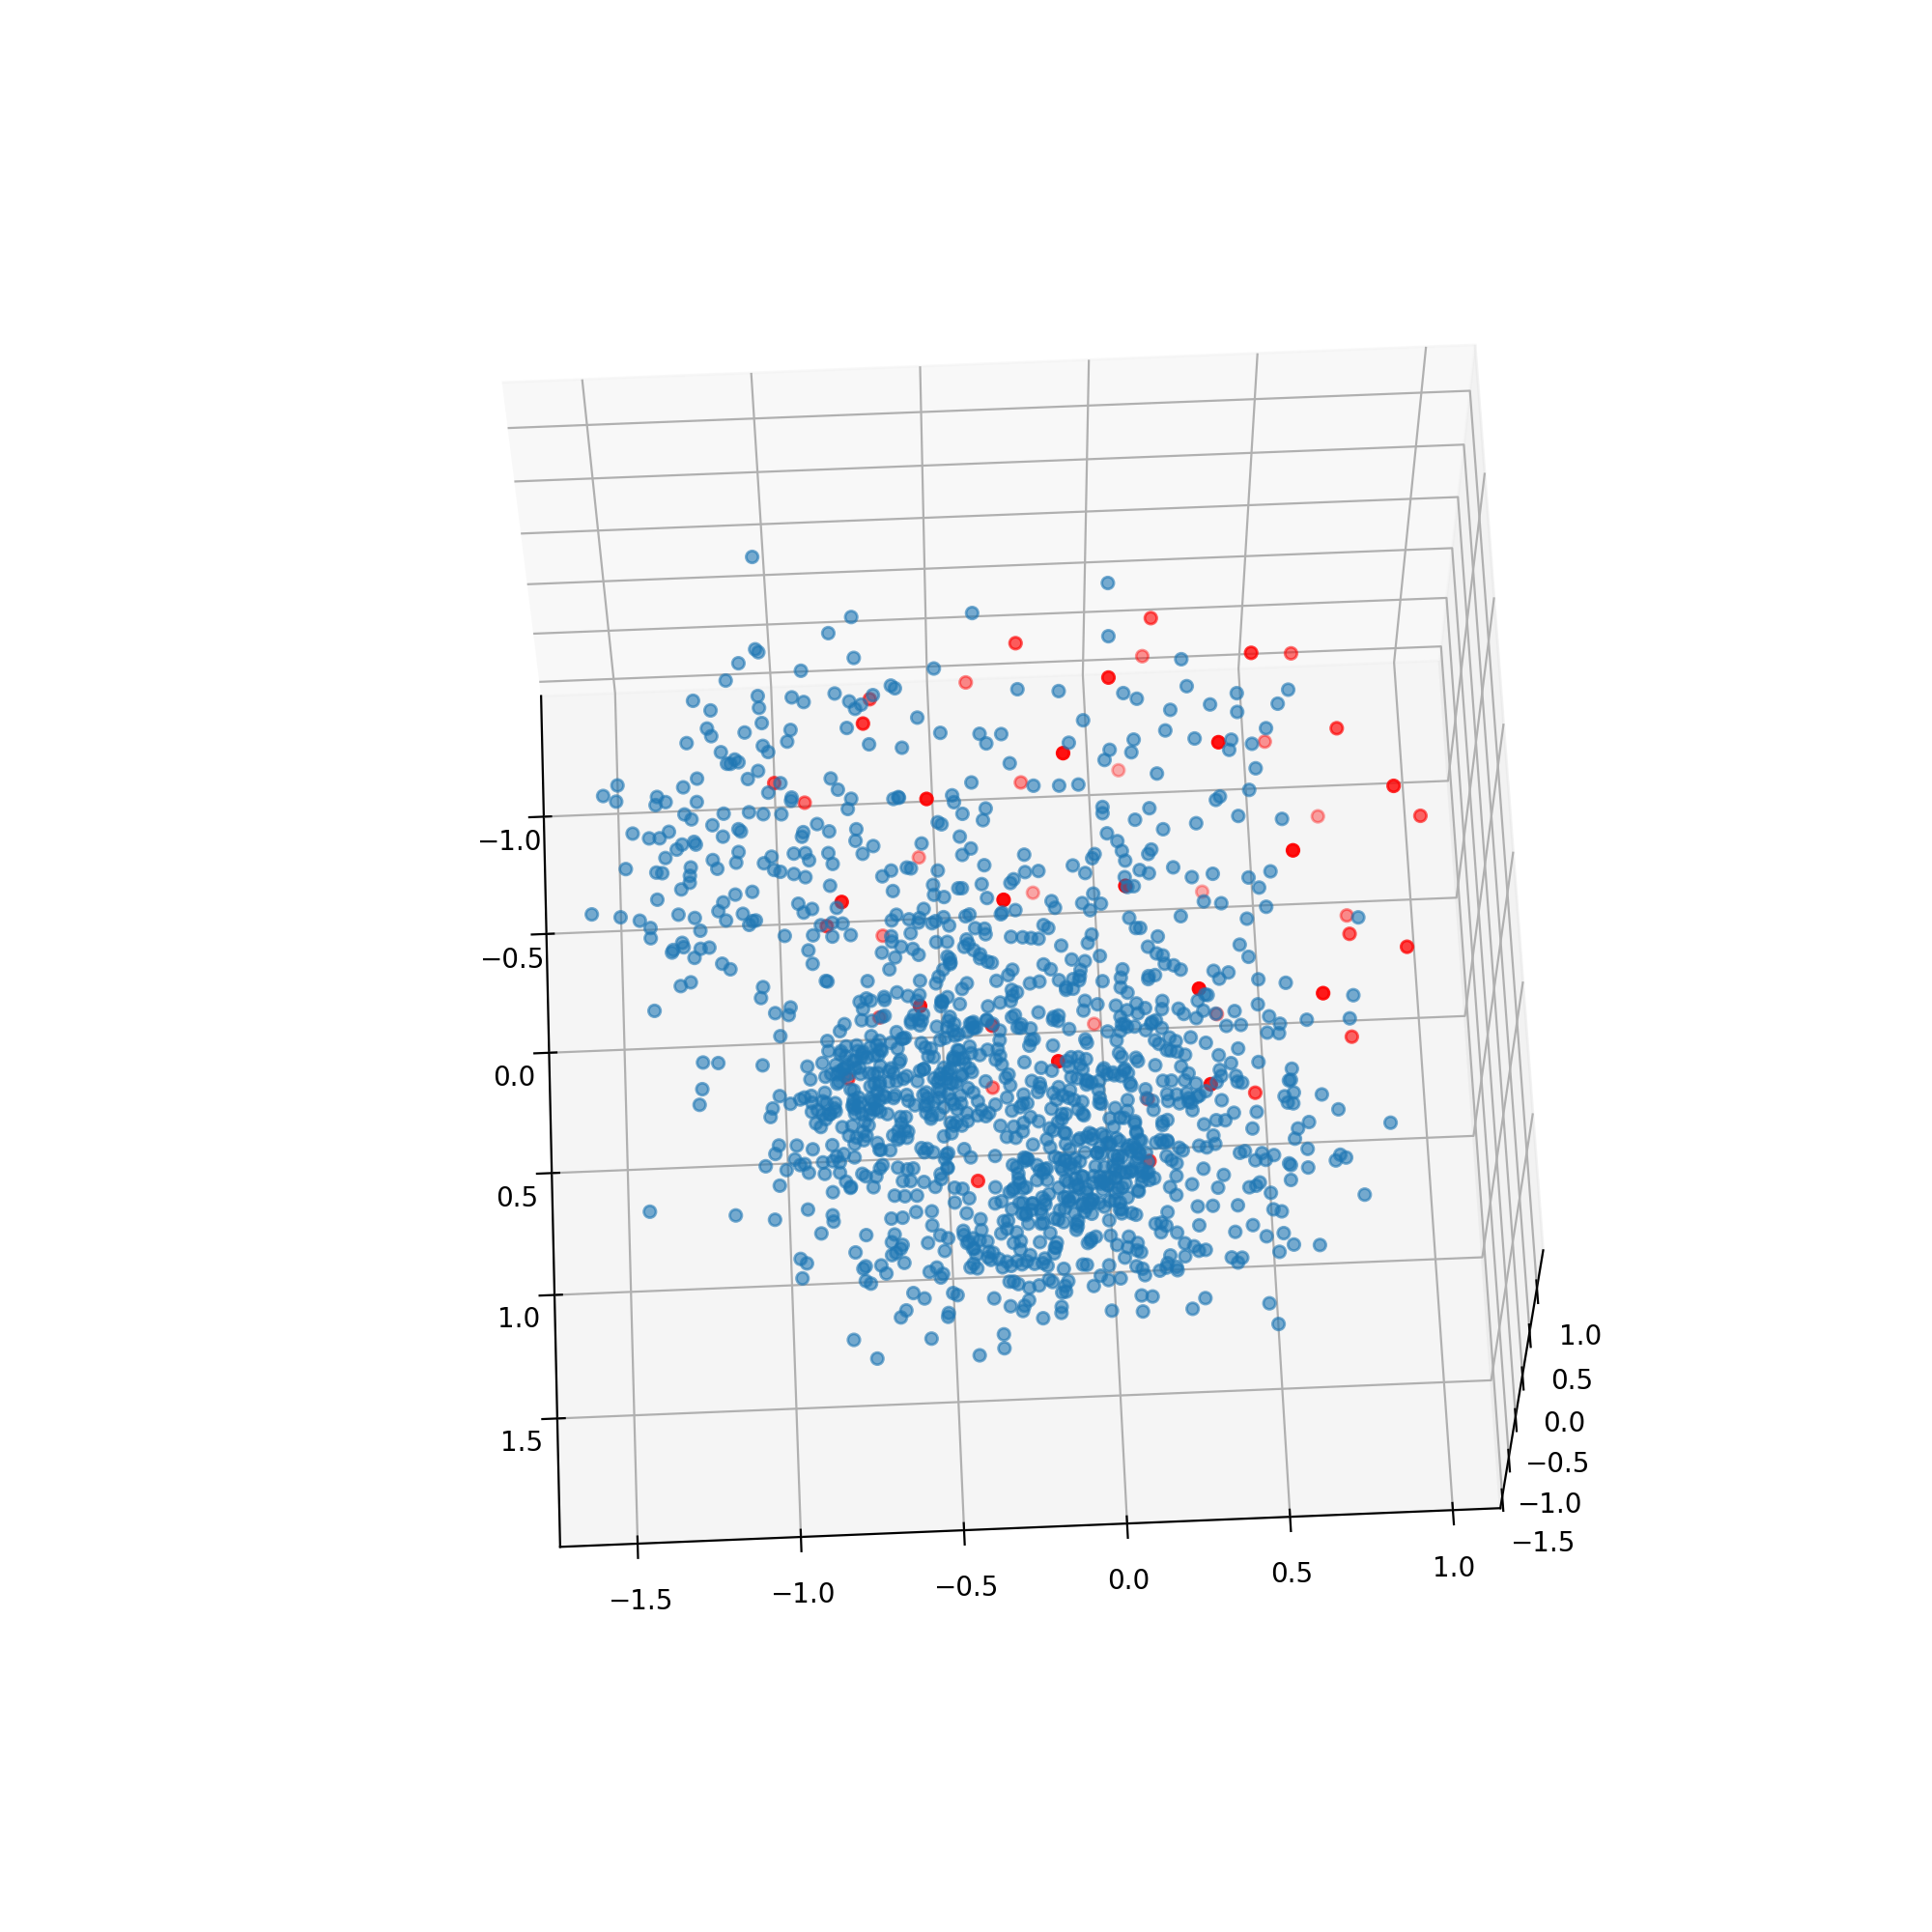

In [80]:
from matplotlib import animation
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# ax.axes.set_xlim3d(left=-30, right=20) 
# ax.axes.set_ylim3d(bottom=-30, top=20) 
# ax.axes.set_zlim3d(bottom=-30, top=20) 

concept_cat = ax.scatter(mean_concept_in_feat_cat_na[0], mean_concept_in_feat_cat_na[1], mean_concept_in_feat_cat_na[2], alpha=0.6) 
ax.scatter(transformed_dist.T[0], transformed_dist.T[1], transformed_dist.T[2], color='red')

# def animate(frame):
#     ax.view_init(60, frame)
#     plt.pause(.0001)
#     return fig

# anim = animation.FuncAnimation(fig, animate, frames=50, interval=.1, repeat=True)
# anim.save('../outputs/feat_concept_rotate.gif', writer='pillow')

plt.show()

<IPython.core.display.Javascript object>


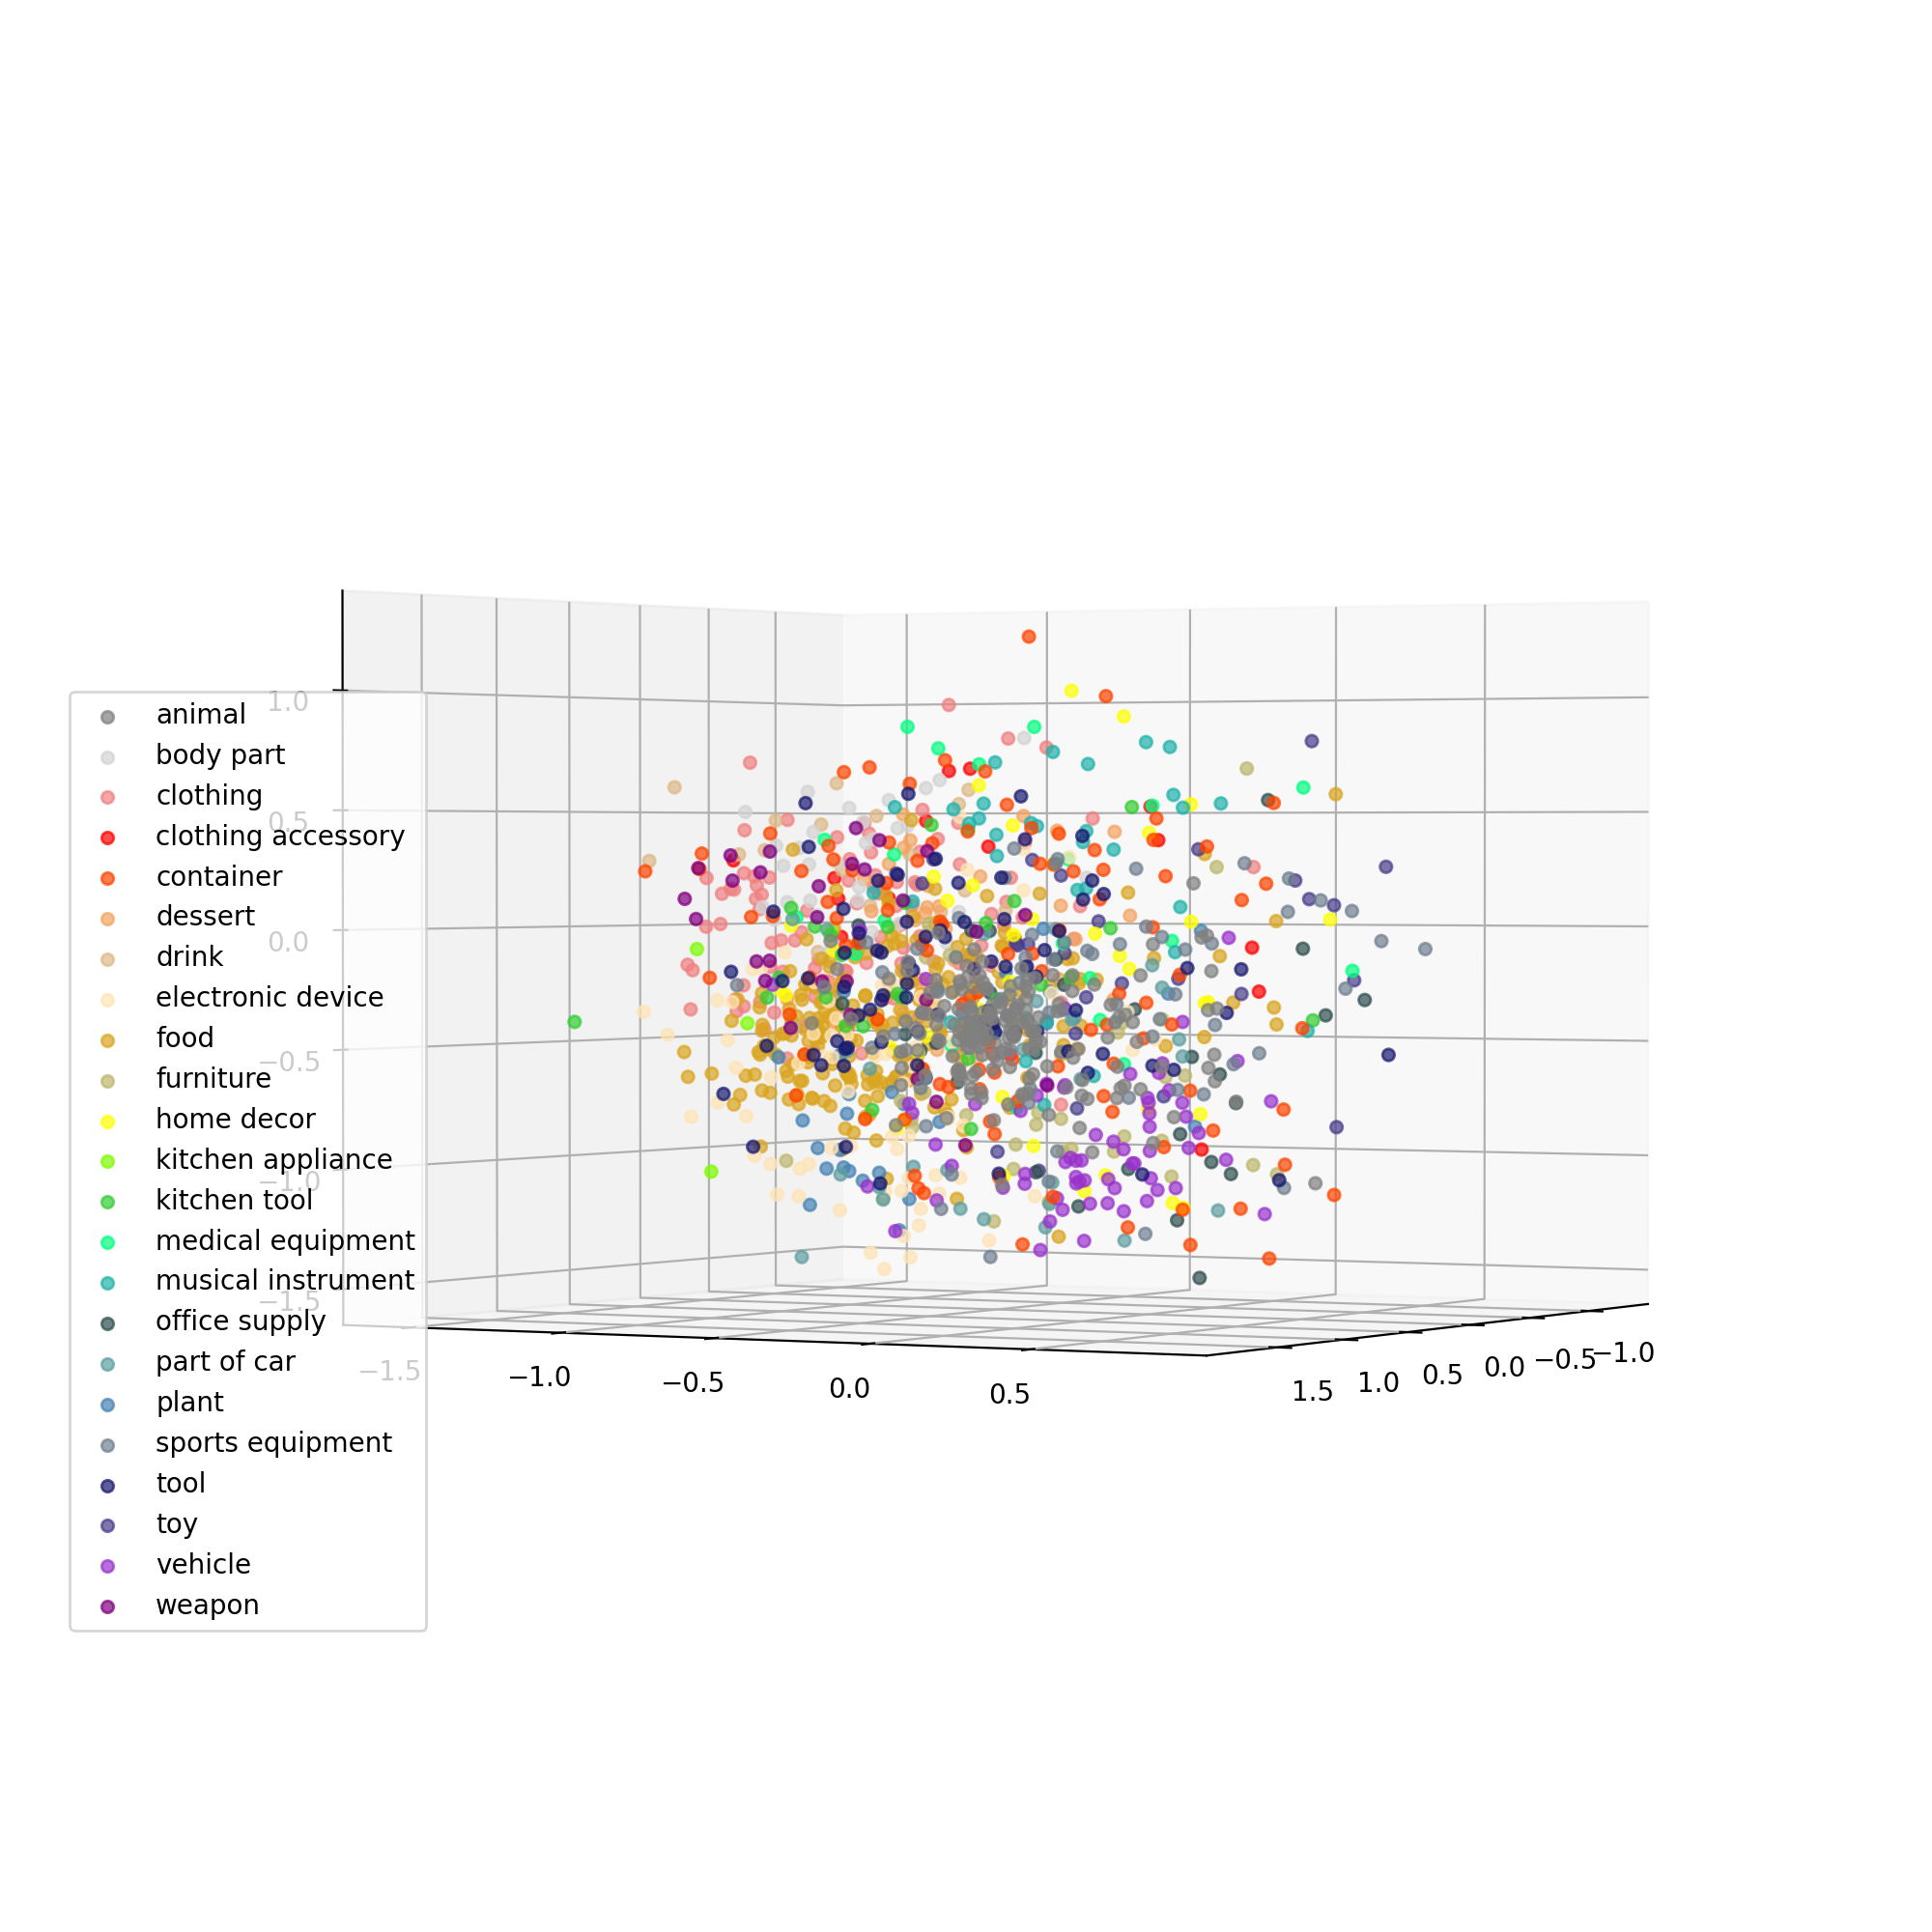

In [81]:
### color by categories: repeat color assignment
import matplotlib.colors as mcolors
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

groups = mean_concept_in_feat_cat_na.groupby("cat_name")
i = 3
for name, group in groups:
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
    i = i+6
plt.legend(bbox_to_anchor=(0.13,0.7))

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


### Cartesian

In [9]:
coordinates = mean_concept_in_feat_cat.loc[:, 0:2]
coordinates

,0,1,2
0,1.039550,0.005882,-0.358634
1,0.306624,0.133821,-0.758165
2,0.857948,-0.024155,-0.545741
3,0.553915,-0.262857,-0.382733
4,0.631593,-0.094784,-1.120267
...,...,...,...
1849,1.177456,-0.462576,-0.323736
1850,0.543909,-0.359043,-0.042410
1851,0.853482,0.278937,-0.651413
1852,0.630059,-0.821717,-0.327458


In [10]:
### linreg: cartesian coordinates and z-score memorability
# Euclidean: R^2 = 0.271, adjusted = 0.265
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(coordinates, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     82.33
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           5.39e-50
Time:                        13:56:53   Log-Likelihood:                -2514.5
No. Observations:                1854   AIC:                             5037.
Df Residuals:                    1850   BIC:                             5059.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3509      0.038     -9.114      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
### create a new table to store all regression results
results_index = ['rsquared', 'rsquared_adj', 'coef', 'pvalues', 'AIC', 'BIC', 'F-statistic', 'F-stats-prob', 'Log-Likelihood']
results = pd.DataFrame({'cart_coord_mem':[res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]}, index=results_index)
results

,cart_coord_mem
rsquared,0.117779
rsquared_adj,0.116349
coef,"[-0.350882959178312, -0.38146830003140764, 0.2..."
pvalues,"[2.0051229900709605e-19, 2.4608746441777825e-1..."
AIC,5037.093576
BIC,5059.193979
F-statistic,82.32704
F-stats-prob,0.0
Log-Likelihood,-2514.546788


### Polar coordinates

In [12]:
# ### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(coordinates.values).T
# plt.hist2d(theta, rho,
#            bins = 20)

### Radius
small R^2, with concepts closer to the core/origin being more memorable

<IPython.core.display.Javascript object>


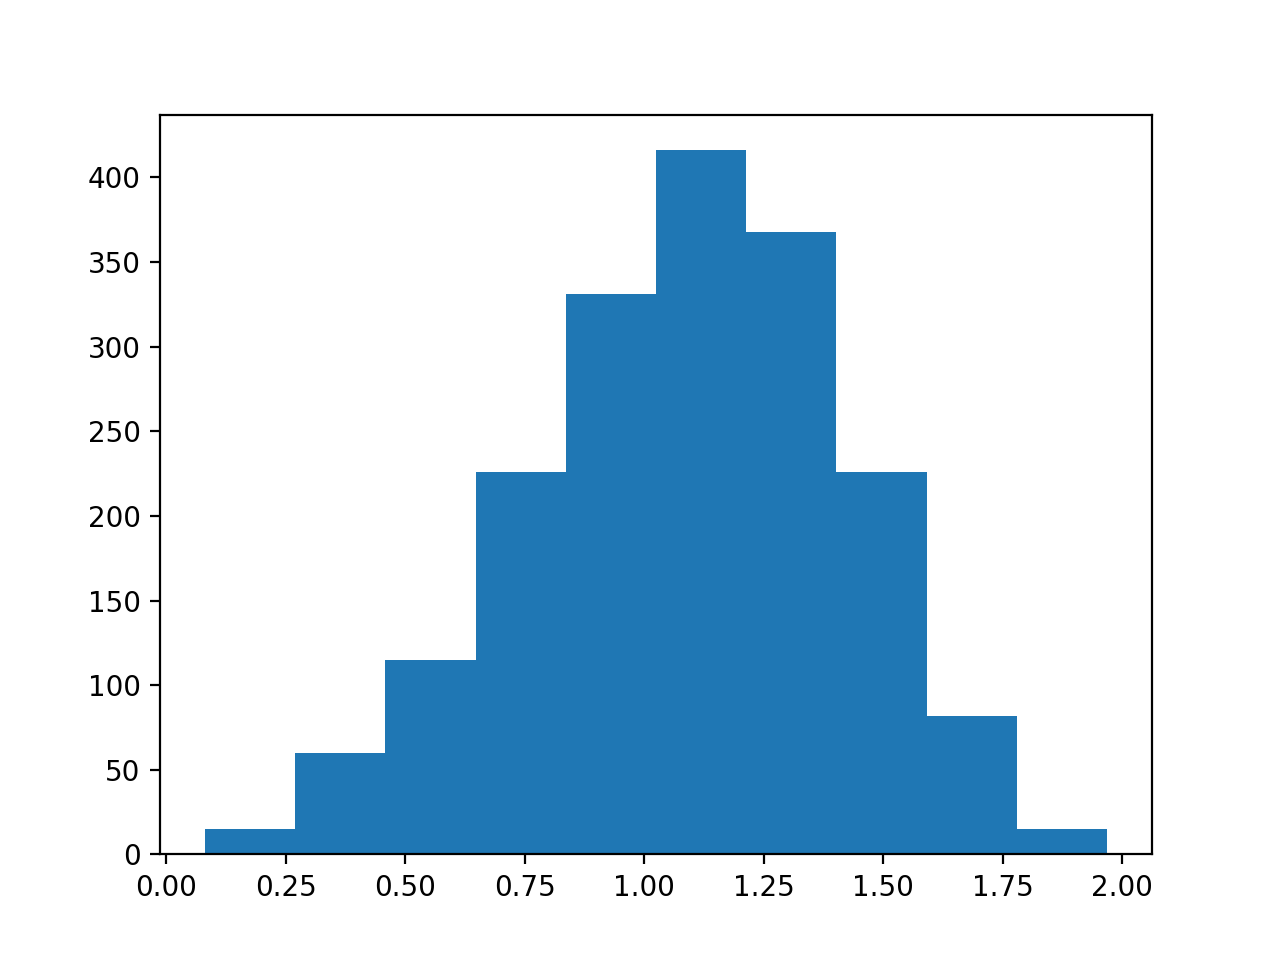

(array([ 15.,  60., 115., 226., 331., 416., 368., 226.,  82.,  15.]),
 array([0.08129886, 0.27001541, 0.45873196, 0.64744851, 0.83616506,
        1.02488161, 1.21359816, 1.40231471, 1.59103126, 1.77974781,
        1.96846436]),
 <BarContainer object of 10 artists>)

In [13]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((coordinates**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [14]:
### Radius vs. memorability
# Euclidean: R^2 = 0.006, adjsuted = 0.005
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary(xname=['radius','const']))

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     16.49
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           5.09e-05
Time:                        13:57:37   Log-Likelihood:                -2622.5
No. Observations:                1854   AIC:                             5249.
Df Residuals:                    1852   BIC:                             5260.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.2848      0.070     -4.061      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [15]:
results['radius_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]
results


,cart_coord_mem,radius_mem
rsquared,0.117779,0.008826
rsquared_adj,0.116349,0.008291
coef,"[-0.350882959178312, -0.38146830003140764, 0.2...","[-0.28478372260425167, 0.3090465789763412]"
pvalues,"[2.0051229900709605e-19, 2.4608746441777825e-1...","[5.088969715951176e-05, 0.00010572144145597052]"
AIC,5037.093576,5248.987245
BIC,5059.193979,5260.037447
F-statistic,82.32704,16.492103
F-stats-prob,0.0,0.000051
Log-Likelihood,-2514.546788,-2622.493623


### KMeans

In [16]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(coordinates)
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)
print(inertia)

[1460.8080528715936, 987.8056284127915, 771.847966813928, 661.5296855291184, 563.9495794514473, 489.3814262973716, 449.05687488769144, 409.5727004270659, 380.6459099705572, 355.3018090281644, 330.2626683891079, 315.94974583987135, 295.95099260683395, 281.3696227885063]


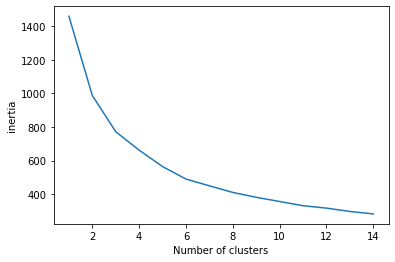

In [17]:
%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()
    

In [18]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=3, random_state=42).fit(coordinates)
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[ 0.5035274 , -0.12188549, -0.86547531],
       [ 0.96145321, -0.30884205, -0.19739283],
       [-0.19625595, -0.55601574,  0.05609919]])

<IPython.core.display.Javascript object>


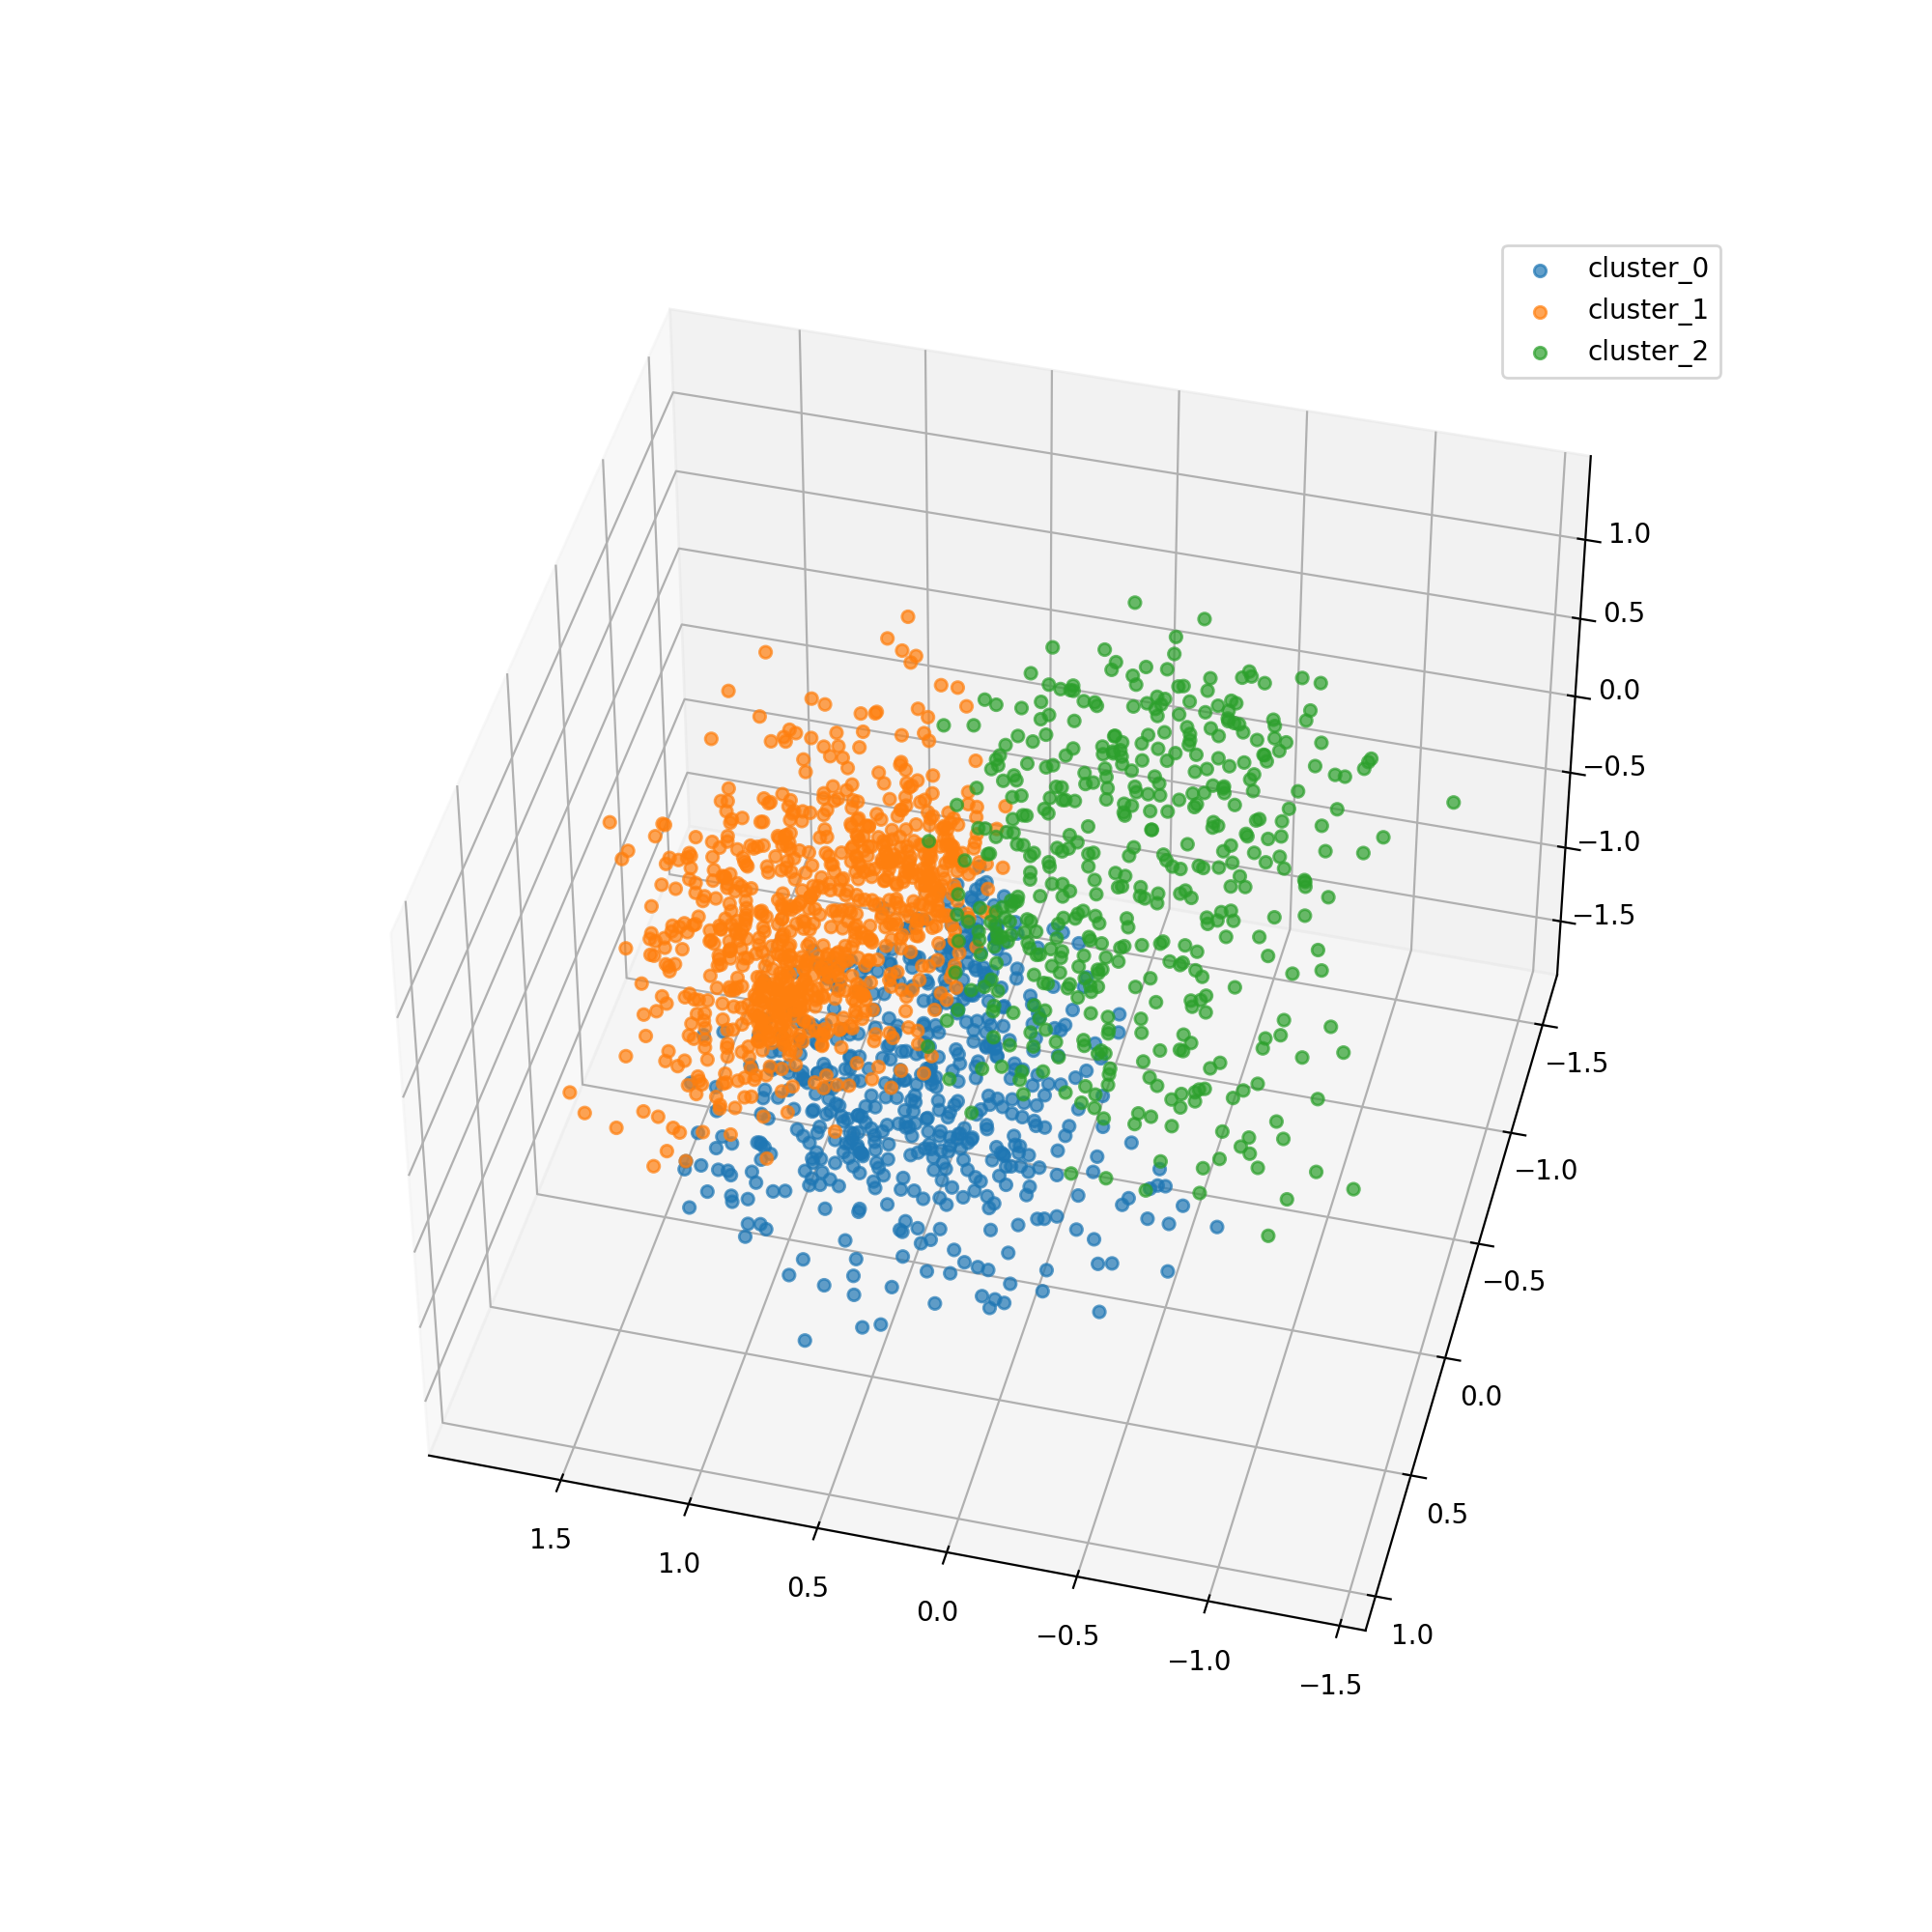

In [75]:
%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.7)
ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.7)
ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.7)
plt.legend()


In [19]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:2], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     13.04
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           3.12e-08
Time:                        13:58:15   Log-Likelihood:                -755.72
No. Observations:                 546   AIC:                             1519.
Df Residuals:                     542   BIC:                             1537.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4723      0.111     -4.265      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
results['cluster_cart_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]
results

,cart_coord_mem,radius_mem,cluster_cart_mem
rsquared,0.117779,0.008826,[0.06729964950401068]
rsquared_adj,0.116349,0.008291,[0.06213710143853468]
coef,"[-0.350882959178312, -0.38146830003140764, 0.2...","[-0.28478372260425167, 0.3090465789763412]","[[-0.472253602043184, -0.2593051650992285, 0.5..."
pvalues,"[2.0051229900709605e-19, 2.4608746441777825e-1...","[5.088969715951176e-05, 0.00010572144145597052]","[[2.3585985864239666e-05, 0.01380082555240139,..."
AIC,5037.093576,5248.987245,[1519.4403498447184]
BIC,5059.193979,5260.037447,[1536.650825747698]
F-statistic,82.32704,16.492103,[13.036130346963873]
F-stats-prob,0.0,0.000051,[3.1213059813036015e-08]
Log-Likelihood,-2514.546788,-2622.493623,[-755.7201749223592]


In [21]:
### cluster 0: radius vs. memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:2]**2).sum(1)), prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     26.69
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           3.36e-07
Time:                        13:58:24   Log-Likelihood:                -761.66
No. Observations:                 546   AIC:                             1527.
Df Residuals:                     544   BIC:                             1536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7030      0.136     -5.166      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [22]:
results['cluster_radius_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]
results

,cart_coord_mem,radius_mem,cluster_cart_mem,cluster_radius_mem
rsquared,0.117779,0.008826,[0.06729964950401068],[0.04676936171496049]
rsquared_adj,0.116349,0.008291,[0.06213710143853468],[0.04501709951223054]
coef,"[-0.350882959178312, -0.38146830003140764, 0.2...","[-0.28478372260425167, 0.3090465789763412]","[[-0.472253602043184, -0.2593051650992285, 0.5...","[[-0.7029923969544134, 0.8033758072499975]]"
pvalues,"[2.0051229900709605e-19, 2.4608746441777825e-1...","[5.088969715951176e-05, 0.00010572144145597052]","[[2.3585985864239666e-05, 0.01380082555240139,...","[[3.35651580187131e-07, 8.190033797194687e-07]]"
AIC,5037.093576,5248.987245,[1519.4403498447184],[1527.3283563817922]
BIC,5059.193979,5260.037447,[1536.650825747698],[1535.933594333282]
F-statistic,82.32704,16.492103,[13.036130346963873],[26.69084663362506]
F-stats-prob,0.0,0.000051,[3.1213059813036015e-08],[3.356515801870614e-07]
Log-Likelihood,-2514.546788,-2622.493623,[-755.7201749223592],[-761.6641781908961]


In [23]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:2], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     10.80
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           5.77e-07
Time:                        13:58:44   Log-Likelihood:                -1184.5
No. Observations:                 846   AIC:                             2377.
Df Residuals:                     842   BIC:                             2396.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.5958      0.118     -5.045      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [24]:
row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [25]:
### cluster 1: radius vs. memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:2]**2).sum(1)), prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     12.57
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           0.000413
Time:                        13:58:51   Log-Likelihood:                -1194.2
No. Observations:                 846   AIC:                             2392.
Df Residuals:                     844   BIC:                             2402.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4179      0.118     -3.546      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [27]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:2], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     28.25
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           8.87e-17
Time:                        13:58:56   Log-Likelihood:                -616.33
No. Observations:                 462   AIC:                             1241.
Df Residuals:                     458   BIC:                             1257.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.5998      0.113     -5.296      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [29]:
### cluster 2: radius vs. memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:2]**2).sum(1)), prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     58.15
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.40e-13
Time:                        13:59:03   Log-Likelihood:                -628.05
No. Observations:                 462   AIC:                             1260.
Df Residuals:                     460   BIC:                             1268.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.9529      0.125      7.626      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [30]:
row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [31]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:2], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


ValueError: zero-size array to reduction operation maximum which has no identity

In [32]:
row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [33]:
### cluster 3: radius vs. memorability
radius_cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(radius_cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_3.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.386
Date:                Wed, 05 Oct 2022   Prob (F-statistic):              0.240
Time:                        14:27:56   Log-Likelihood:                -442.01
No. Observations:                 312   AIC:                             888.0
Df Residuals:                     310   BIC:                             895.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.5953      0.506     -1.177      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [32]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
#  + sum((zscore_mem_3 - res_3.fittedvalues)**2)
#  + sum((zscore_mem_3 - zscore_mem_3.mean())**2)
results.iloc[0]['cluster_cart_mem'].append(r_squared)
r_squared

0.07563595869617368

In [34]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
# + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)
# + sum((zscore_mem_3 - zscore_mem_3.mean())**2)
results.iloc[0]['cluster_radius_mem'].append(r_squared)
r_squared

0.04843715117426772

### Typicality

In [35]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [36]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,cr,bigcat,cat_name,typicality
0,0,1.039550,0.005882,-0.358634,0.779739,1,animal,0.810913
1,1,0.306624,0.133821,-0.758165,0.798485,13,home decor,0.247628
2,2,0.857948,-0.024155,-0.545741,0.752845,18,musical instrument,0.624589
4,4,0.631593,-0.094784,-1.120267,0.794466,9,electronic device,0.522380
5,5,0.322682,-0.226267,-0.834044,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...
1847,1847,-0.337758,0.398110,0.799413,0.803129,24,toy,0.246697
1848,1848,0.726302,-0.806779,-0.045612,0.765881,10,food,0.786900
1850,1850,0.543909,-0.359043,-0.042410,0.843158,10,food,0.770485
1851,1851,0.853482,0.278937,-0.651413,0.800163,1,animal,0.764335


In [37]:
### Cartesian coordinates vs. typicality
# Euclidean: R^2 = 0.492, adjusted = 0.485
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped.loc[:, 0:2], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     76.18
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.90e-45
Time:                        14:01:49   Log-Likelihood:                -1773.0
No. Observations:                1324   AIC:                             3554.
Df Residuals:                    1320   BIC:                             3575.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.5065      0.047     10.692      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [38]:
### Radius vs. typicality
# Euclidean: R^2 = 0.023, adjusted = 0.023
# normalized: R^2 = 0.388, adjusted = 0.388

concept_radius_typ = np.sqrt((grouped.loc[:, 0:2]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius', 'const']))
results['radius_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     27.89
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.50e-07
Time:                        14:01:54   Log-Likelihood:                -1864.9
No. Observations:                1324   AIC:                             3734.
Df Residuals:                    1322   BIC:                             3744.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius         0.4462      0.084      5.281      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [42]:
### Cartesian coordinates and typicality vs. memorability
# Euclidean: R^2 = 0.301, adjusted = 0.292
# normalized: R^2 = 0.107, adjusted = 0.104

zscore_mem = stats.zscore(grouped['cr'])
idx = [i for i in range(0, 3)]
idx.append('typicality')
mean_concept_constant = sm.add_constant(np.array(grouped[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['x', 'y', 'z', 'typicality', 'const']))
results['cart_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     65.19
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           2.37e-50
Time:                        14:03:50   Log-Likelihood:                -1759.3
No. Observations:                1324   AIC:                             3529.
Df Residuals:                    1319   BIC:                             3554.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x             -0.4089      0.049     -8.365      0.0

In [43]:
### Radius and typicality vs. memorability
# Euclidean: R^2 = 0.041, adjusted = 0.040
# normalized: R^2 = 0.046, adjusted = 0.044

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_typ, grouped['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius','typicality', 'const']))
results['radius_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     30.80
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           8.44e-14
Time:                        14:03:57   Log-Likelihood:                -1848.5
No. Observations:                1324   AIC:                             3703.
Df Residuals:                    1321   BIC:                             3719.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.3513      0.084     -4.165      0.0

##### Cluster level typicality

In [44]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,cr,bigcat,cat_name,label,typicality
0,0,1.039550,0.005882,-0.358634,0.779739,1,animal,1,0.810913
1,1,0.306624,0.133821,-0.758165,0.798485,13,home decor,0,0.247628
2,2,0.857948,-0.024155,-0.545741,0.752845,18,musical instrument,1,0.624589
3,4,0.631593,-0.094784,-1.120267,0.794466,9,electronic device,0,0.522380
4,5,0.322682,-0.226267,-0.834044,0.806000,12,furniture,0,0.509185
...,...,...,...,...,...,...,...,...,...
1319,1847,-0.337758,0.398110,0.799413,0.803129,24,toy,2,0.246697
1320,1848,0.726302,-0.806779,-0.045612,0.765881,10,food,1,0.786900
1321,1850,0.543909,-0.359043,-0.042410,0.843158,10,food,1,0.770485
1322,1851,0.853482,0.278937,-0.651413,0.800163,1,animal,0,0.764335


In [45]:
### cluster 0: cartesian coordinates + typicality vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[idx], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     6.751
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           3.13e-05
Time:                        14:04:06   Log-Likelihood:                -457.92
No. Observations:                 332   AIC:                             925.8
Df Residuals:                     327   BIC:                             944.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2951      0.164     -1.797      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [46]:
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['typicality'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:2], prepend=False)
mod_0_typ = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0_typ = mod_0_typ.fit()
print(res_0_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     35.23
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           9.19e-20
Time:                        14:04:15   Log-Likelihood:                -424.72
No. Observations:                 332   AIC:                             857.4
Df Residuals:                     328   BIC:                             872.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.8215      0.141      5.818      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [47]:
### cluster 0: radius + typicality vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:2]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     11.29
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.82e-05
Time:                        14:04:22   Log-Likelihood:                -460.07
No. Observations:                 332   AIC:                             926.1
Df Residuals:                     329   BIC:                             937.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.8127      0.180     -4.514      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [48]:
### cluster 1: cartesian coordinates + typicality vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[idx], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     22.20
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           3.24e-17
Time:                        14:04:31   Log-Likelihood:                -905.88
No. Observations:                 668   AIC:                             1822.
Df Residuals:                     663   BIC:                             1844.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4731      0.130     -3.648      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [49]:
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['typicality'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:2], prepend=False)
mod_1_typ = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1_typ = mod_1_typ.fit()
print(res_1_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     28.25
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           3.35e-17
Time:                        14:04:36   Log-Likelihood:                -907.73
No. Observations:                 668   AIC:                             1823.
Df Residuals:                     664   BIC:                             1841.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4872      0.129     -3.789      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [50]:
### cluster 1: radius + typicality vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:2]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     42.78
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           3.33e-18
Time:                        14:04:44   Log-Likelihood:                -907.42
No. Observations:                 668   AIC:                             1821.
Df Residuals:                     665   BIC:                             1834.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4567      0.128     -3.554      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [51]:
### cluster 2: cartesian coordinates + typicality vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[idx], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     17.75
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           3.60e-13
Time:                        14:04:47   Log-Likelihood:                -427.18
No. Observations:                 324   AIC:                             864.4
Df Residuals:                     319   BIC:                             883.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.6322      0.141     -4.494      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [52]:
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['typicality'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:2], prepend=False)
mod_2_typ = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2_typ = mod_2_typ.fit()
print(res_2_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     32.51
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           2.27e-18
Time:                        14:04:52   Log-Likelihood:                -416.63
No. Observations:                 324   AIC:                             841.3
Df Residuals:                     320   BIC:                             856.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.4212      0.134      3.146      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [53]:
### cluster 2: radius + typicality vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:2]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     29.52
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.70e-12
Time:                        14:04:56   Log-Likelihood:                -432.38
No. Observations:                 324   AIC:                             870.8
Df Residuals:                     321   BIC:                             882.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.9930      0.151      6.581      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [54]:
### cluster 3: cartesian coordinates + typicality vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[idx], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


ValueError: zero-size array to reduction operation maximum which has no identity

In [55]:
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['typicality'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:2], prepend=False)
mod_3_typ = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3_typ = mod_3_typ.fit()
print(res_3_typ.summary())

ValueError: zero-size array to reduction operation maximum which has no identity

In [51]:
### cluster 3: radius + typicality vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     19.15
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.81e-08
Time:                        14:27:56   Log-Likelihood:                -343.79
No. Observations:                 255   AIC:                             693.6
Df Residuals:                     252   BIC:                             704.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.8979      0.552     -1.628      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Taking typicality into account, on cluster level, coordinates and typicality of concepts in euclidean space explained more variance in memorability compared to coordinates only. 

In [56]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
# + sum((zscore_mem_3 - res_3.fittedvalues)**2)
# + sum((zscore_mem_3 - zscore_mem_3.mean())**2)
results.iloc[0]['cluster_cart_typ_mem'].append(r_squared)
r_squared

0.12326654401726567

In [57]:
r_squared = 1 - (sum((zscore_mem_0 - res_0_typ.fittedvalues)**2) + sum((zscore_mem_1 - res_1_typ.fittedvalues)**2) + sum((zscore_mem_2 - res_2_typ.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
# + sum((zscore_mem_3 - res_3_typ.fittedvalues)**2)
# + sum((zscore_mem_3 - zscore_mem_3.mean())**2)
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

-0.061063237934353864

In [58]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
# + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)
# + sum((zscore_mem_3 - zscore_mem_3.mean())**2)
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

0.11163331547908362

In [59]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     88.22
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.09e-36
Time:                        14:07:18   Log-Likelihood:                -1795.7
No. Observations:                1324   AIC:                             3597.
Df Residuals:                    1321   BIC:                             3613.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4172      0.037     11.336      0.0

### Typicality calculated by cluster

In [60]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,cr,bigcat,cat_name,label,typicality
0,0,1.039550,0.005882,-0.358634,0.779739,1,animal,1,0.226554
1,1,0.306624,0.133821,-0.758165,0.798485,13,home decor,0,0.165695
2,2,0.857948,-0.024155,-0.545741,0.752845,18,musical instrument,1,0.071280
3,4,0.631593,-0.094784,-1.120267,0.794466,9,electronic device,0,0.151594
4,5,0.322682,-0.226267,-0.834044,0.806000,12,furniture,0,0.187742
...,...,...,...,...,...,...,...,...,...
1319,1847,-0.337758,0.398110,0.799413,0.803129,24,toy,2,0.091360
1320,1848,0.726302,-0.806779,-0.045612,0.765881,10,food,1,0.271938
1321,1850,0.543909,-0.359043,-0.042410,0.843158,10,food,1,0.267550
1322,1851,0.853482,0.278937,-0.651413,0.800163,1,animal,0,0.046471


In [61]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     52.88
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           2.33e-41
Time:                        14:07:43   Log-Likelihood:                -1780.2
No. Observations:                1324   AIC:                             3570.
Df Residuals:                    1319   BIC:                             3596.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3404      0.049     -7.018      0.0

In [62]:
### overall cartesian vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx[:-1]]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     161.9
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           2.29e-89
Time:                        14:07:51   Log-Likelihood:                -1671.2
No. Observations:                1324   AIC:                             3350.
Df Residuals:                    1320   BIC:                             3371.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3042      0.044      6.935      0.0

In [63]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters.loc[:, 0:2]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     38.28
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           6.90e-17
Time:                        14:07:55   Log-Likelihood:                -1841.4
No. Observations:                1324   AIC:                             3689.
Df Residuals:                    1321   BIC:                             3704.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5366      0.090     -5.996      0.0

In [64]:
### overall radius vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_clus, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     214.2
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           4.47e-45
Time:                        14:07:58   Log-Likelihood:                -1779.2
No. Observations:                1324   AIC:                             3562.
Df Residuals:                    1322   BIC:                             3573.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.1591      0.079     14.637      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [65]:
### cluster 0: cartesian coordinates and typicality vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_0[idx]), prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_clust_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     6.628
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           3.86e-05
Time:                        14:08:00   Log-Likelihood:                -458.15
No. Observations:                 332   AIC:                             926.3
Df Residuals:                     327   BIC:                             945.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2665      0.165     -1.620      0.1

In [66]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:2]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_clust_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     8.899
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           0.000172
Time:                        14:08:04   Log-Likelihood:                -462.34
No. Observations:                 332   AIC:                             930.7
Df Residuals:                     329   BIC:                             942.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7566      0.199     -3.810      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [67]:
### cluster 1: cartesian coordinates and typicality vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_1[idx]), prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     10.30
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           4.23e-08
Time:                        14:08:06   Log-Likelihood:                -927.71
No. Observations:                 668   AIC:                             1865.
Df Residuals:                     663   BIC:                             1888.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6351      0.133     -4.785      0.0

In [68]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:2]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     17.18
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           5.32e-08
Time:                        14:08:09   Log-Likelihood:                -931.03
No. Observations:                 668   AIC:                             1868.
Df Residuals:                     665   BIC:                             1882.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.5647      0.134     -4.200      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [69]:
### cluster 2: cartesian coordinates and typicality vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_2[idx]), prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     18.28
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.55e-13
Time:                        14:08:13   Log-Likelihood:                -426.30
No. Observations:                 324   AIC:                             862.6
Df Residuals:                     319   BIC:                             881.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3566      0.152     -2.348      0.0

In [70]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:2]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     30.81
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           5.74e-13
Time:                        14:08:15   Log-Likelihood:                -431.29
No. Observations:                 324   AIC:                             868.6
Df Residuals:                     321   BIC:                             879.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.6845      0.197      3.482      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [71]:
### cluster 3: cartesian coordinates and typicality vs. memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_3[idx]), prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

ValueError: zero-size array to reduction operation maximum which has no identity

In [67]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     21.11
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.35e-09
Time:                        14:27:56   Log-Likelihood:                -342.08
No. Observations:                 255   AIC:                             690.2
Df Residuals:                     252   BIC:                             700.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3695      0.564     -0.655      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [72]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
# + sum((zscore_mem_3 - res_3.fittedvalues)**2)
# + sum((zscore_mem_3 - zscore_mem_3.mean())**2)
results.iloc[0]['cluster_cart_clust_typ_mem'].append(r_squared)
r_squared

0.09397641057920114

In [73]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
# + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)
# + sum((zscore_mem_3 - zscore_mem_3.mean())**2)
results.iloc[0]['cluster_radius_clust_typ_mem'].append(r_squared)
r_squared

0.07706751092750697

In [74]:
results.to_csv('../outputs/euclidean_3d_reg_results.csv')